# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-expressions'
GENDER_FILE_PATH = data_path / 'gender-recognizer'

train_emotion_dir = EMOTION_FILE_PATH / 'images/train'
test_emotion_dir = EMOTION_FILE_PATH / 'images/validation'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-expressions'),
 PosixPath('/kaggle/input/gender-recognizer'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/gender-recognizer
There are 2 directories and 0 images in /kaggle/input/gender-recognizer/dataset
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/MEN
There are 1 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN
There are 0 directories and 646 images in /kaggle/input/gender-recognizer/dataset/WOMAN/MEN


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
        'label': [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH)
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH)
print(gender_df.head())

                                        file_path file_name label
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png   057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png   057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png   057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png   057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png   057
                                           file_path            file_name  \
0  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_112131.jpg   
1  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_133142.jpg   
2  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160304.jpg   
3  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240609_200332.jpg   
4  /kaggle/input/gender-recognizer/dataset/MEN/20...  20240705_160729.jpg   

  label  
0   MEN  
1   MEN  
2   MEN  
3   MEN  
4   MEN  


In [11]:
age_df.shape, gender_df.shape

((19556, 3), (1937, 3))

In [12]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'label']).sum())
age_df.drop_duplicates(['file_name', 'label'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'label']).sum())
gender_df.drop_duplicates(['file_name', 'label'], inplace=True)

9778
646


In [13]:
age_df.shape, gender_df.shape

((9778, 3), (1291, 3))

In [14]:
# Define bins and labels
age_bins = [0, 3, 12, 19, 28, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Young Adult', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['label'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}


,file_path,file_name,label,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [15]:
gender_df['label'].str.lower()
gender_df.head()

,file_path,file_name,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_112131.jpg,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_133142.jpg,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160304.jpg,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_200332.jpg,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240705_160729.jpg,MEN


In [16]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

file_path         0
file_name         0
label             0
age_category    794
dtype: int64
file_path    0
file_name    0
label        0
dtype: int64


In [17]:
age_df['age_category'].value_counts()

age_category
Adult          2543
Baby           1587
Child          1562
Young Adult    1280
Elderly        1055
Teen            957
Name: count, dtype: int64

In [18]:
age_df.drop('label', axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 3)


,file_path,file_name,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,Elderly


In [19]:
train_age_data, test_age_data = train_test_split(age_df, shuffle=True, test_size=0.2)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.2)
train_gender_data.head()

                                           file_path file_name age_category
4970  /kaggle/input/facial-age/face_age/013/4808.png  4808.png         Teen
9630  /kaggle/input/facial-age/face_age/030/4096.png  4096.png        Adult
2321  /kaggle/input/facial-age/face_age/001/1342.png  1342.png         Baby
8954  /kaggle/input/facial-age/face_age/010/8281.png  8281.png        Child
2033  /kaggle/input/facial-age/face_age/001/8088.png  8088.png         Baby


,file_path,file_name,label
341,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_183538.jpg,MEN
1016,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0366.jpg,WOMAN
1142,/kaggle/input/gender-recognizer/dataset/WOMAN/...,0359.jpg,WOMAN
361,/kaggle/input/gender-recognizer/dataset/MEN/20...,20240609_203156.jpg,MEN
1205,/kaggle/input/gender-recognizer/dataset/WOMAN/...,3f1923d1-27d5-4422-9607-0f0c38b638b7.jpg,WOMAN


In [20]:
train_age_data.shape, test_age_data.shape

((7187, 3), (1797, 3))

In [21]:
train_gender_data.shape, test_gender_data.shape

((1032, 3), (259, 3))

## 3. Data Transformation for All Dataset

In [22]:
# Define the transformation pipeline
train_transforms_trivial = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply TrivialAugmentWide
    transforms.ToTensor()  # Convert to tensor
])

test_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(224, 224)),  # Resize to 224x224
    transforms.ToTensor()  # Convert to tensor
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for Age and Gender Data

In [23]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, file_paths, categories, idx, transform=None):
        """
        Args:
            file_paths (list): List of image file paths.
            categories (list): List of all categories corresponding to the images.
            idx (dict): Mapping of all categories to numerical indices.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.file_paths = list(file_paths)
        self.categories = list(categories)
        self.idx = idx
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Retrieve image path and age category
        img_path = self.file_paths[idx]
        category = self.categories[idx]

        # Map the age category to its corresponding index
        label_idx = self.idx[category]

        # Load the image
        img = Image.open(img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            img = self.transform(img)

        return img, label_idx

In [24]:
gender_labels = list(train_gender_data['label'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'MEN': 0, 'WOMAN': 1}

In [25]:
# Initialize the datasets for Age Dataset
age_train_dataset = CustomDataset(
    file_paths=train_age_data['file_path'].tolist(),
    categories=train_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=train_transforms_trivial
)

age_test_dataset = CustomDataset(
    file_paths=test_age_data['file_path'].tolist(),
    categories=test_age_data['age_category'].tolist(),
    idx=age_idx,
    transform=test_transforms
)

# Initialize the datasets for Gender Dataset
gender_train_dataset = CustomDataset(
    file_paths=train_gender_data['file_path'].tolist(),
    categories=train_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=train_transforms_trivial
)

gender_test_dataset = CustomDataset(
    file_paths=test_gender_data['file_path'].tolist(),
    categories=test_gender_data['label'].tolist(),
    idx=gender_idx,
    transform=test_transforms
)

In [26]:
# Test the training dataset
img, label_idx = age_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 2


In [27]:
# Test the training dataset
img, label_idx = gender_train_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 224, 224]), Label index: 0


In [28]:
age_train_dataset[3]

(tensor([[[0.5020, 0.5020, 0.5412,  ..., 0.0078, 0.0588, 0.2196],
          [0.4627, 0.5059, 0.5529,  ..., 0.0118, 0.0706, 0.2235],
          [0.4588, 0.5137, 0.5412,  ..., 0.0118, 0.0667, 0.2118],
          ...,
          [0.0078, 0.0118, 0.0078,  ..., 0.4784, 0.4627, 0.4196],
          [0.0353, 0.0510, 0.0235,  ..., 0.4745, 0.4549, 0.4275],
          [0.0392, 0.0863, 0.0667,  ..., 0.4627, 0.4431, 0.4235]],
 
         [[0.0000, 0.0000, 0.0275,  ..., 0.1059, 0.2588, 0.4627],
          [0.0039, 0.0000, 0.0196,  ..., 0.1098, 0.2627, 0.4588],
          [0.0039, 0.0000, 0.0471,  ..., 0.1098, 0.2471, 0.4314],
          ...,
          [0.2078, 0.2000, 0.1961,  ..., 0.6549, 0.6431, 0.6000],
          [0.2039, 0.2157, 0.1843,  ..., 0.6471, 0.6353, 0.6078],
          [0.1843, 0.2314, 0.2078,  ..., 0.6353, 0.6157, 0.6039]],
 
         [[0.8039, 0.7765, 0.7686,  ..., 0.0471, 0.1804, 0.3647],
          [0.7608, 0.7765, 0.7804,  ..., 0.0510, 0.1882, 0.3608],
          [0.7529, 0.7804, 0.7569,  ...,

In [29]:
gender_train_dataset[3]

(tensor([[[0.2588, 0.2588, 0.2549,  ..., 0.0667, 0.0941, 0.1176],
          [0.2627, 0.2588, 0.2588,  ..., 0.0667, 0.0941, 0.1176],
          [0.2627, 0.2627, 0.2588,  ..., 0.0667, 0.0902, 0.1176],
          ...,
          [0.5608, 0.6039, 0.6196,  ..., 0.6510, 0.6902, 0.7176],
          [0.5529, 0.6039, 0.6235,  ..., 0.6588, 0.7020, 0.7216],
          [0.5490, 0.5922, 0.6235,  ..., 0.6667, 0.7098, 0.7216]],
 
         [[0.1922, 0.1922, 0.1882,  ..., 0.0706, 0.0980, 0.1216],
          [0.1961, 0.1922, 0.1922,  ..., 0.0706, 0.0980, 0.1216],
          [0.1961, 0.1961, 0.1922,  ..., 0.0706, 0.0941, 0.1216],
          ...,
          [0.4902, 0.5373, 0.5529,  ..., 0.6039, 0.6431, 0.6784],
          [0.4863, 0.5373, 0.5569,  ..., 0.6157, 0.6627, 0.6824],
          [0.4824, 0.5255, 0.5569,  ..., 0.6235, 0.6667, 0.6824]],
 
         [[0.0902, 0.0902, 0.0863,  ..., 0.0471, 0.0745, 0.0980],
          [0.0941, 0.0902, 0.0902,  ..., 0.0471, 0.0745, 0.0980],
          [0.0941, 0.0941, 0.0902,  ...,

In [30]:
age_train_dataset.idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Young Adult': 3, 'Adult': 4, 'Elderly': 5}

In [31]:
gender_train_dataset.idx

{'MEN': 0, 'WOMAN': 1}

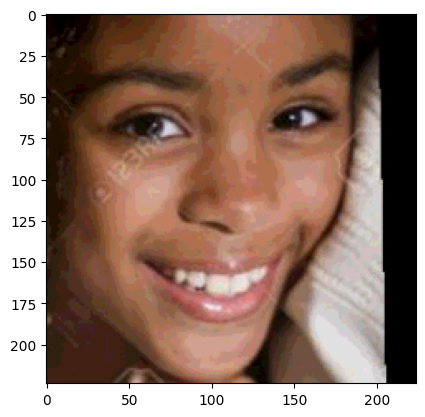

In [32]:
plt.imshow(age_train_dataset[0][0].permute(1, 2, 0))

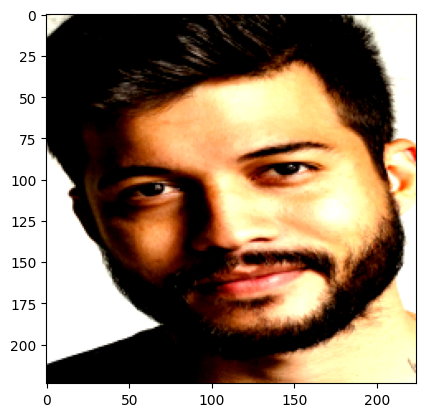

In [33]:
plt.imshow(gender_train_dataset[0][0].permute(1, 2, 0))

In [34]:
import matplotlib.pyplot as plt

# Adjusted display_random_images function
def display_random_images(dataset, classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, label = dataset[idx]
        
        # Convert the tensor to numpy for matplotlib
        img_np = img_tensor.permute(1, 2, 0).numpy()
        
        # Scale pixel values back to [0, 255] for display
        img_np = img_np * 255  # If normalized to [0, 1]
        img_np = img_np.astype("uint8")  # Convert to integers for display

        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        
        title = f"Class: {classes[label]}" if classes else f"Label: {label}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title)

    plt.show()

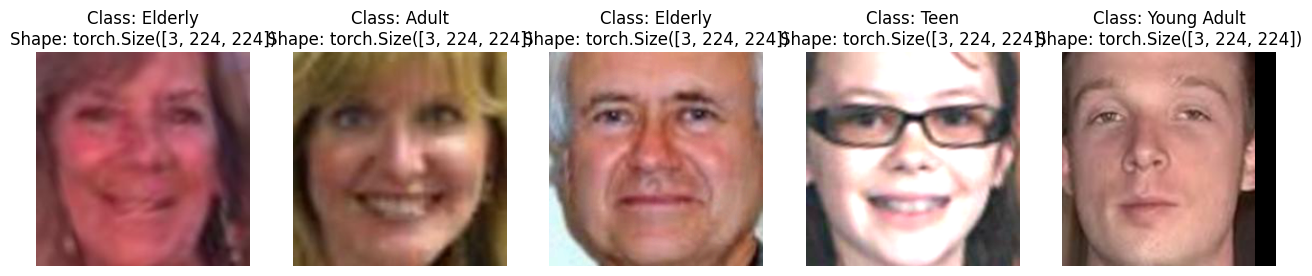

In [35]:
# Display random images from the the Custom Dataset
display_random_images(age_train_dataset, n=5,
                     classes=age_labels, seed=None)

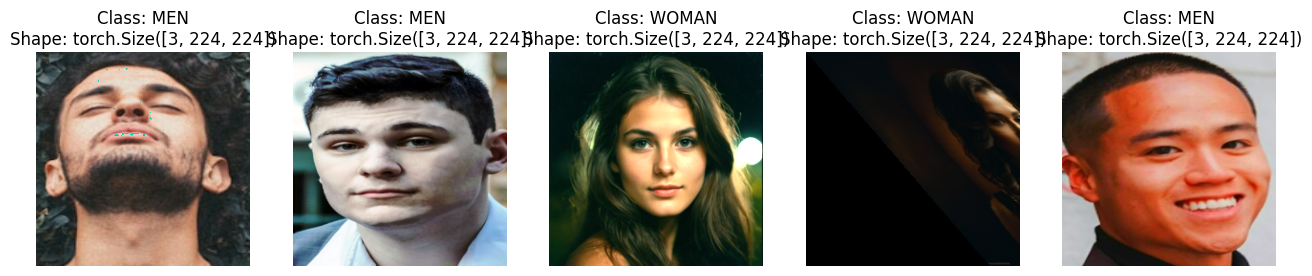

In [36]:
# Display random images from the the Custom Dataset
display_random_images(gender_train_dataset, n=5,
                     classes=gender_labels, seed=None)

### 4.2 Create Emotion Dataset using ImageFolder

In [37]:
# Turn image folders into Datasets
from torchvision import datasets

emotion_train_dataset = datasets.ImageFolder(root=train_emotion_dir,
                                            transform=train_transforms_trivial)

emotion_test_dataset = datasets.ImageFolder(root=test_emotion_dir,
                                        transform=test_transforms)

In [38]:
len(emotion_train_dataset), len(emotion_test_dataset)

(28821, 7066)

In [39]:
emotion_train_dataset[0][0].shape

torch.Size([3, 224, 224])

In [40]:
type(emotion_test_dataset)

torchvision.datasets.folder.ImageFolder

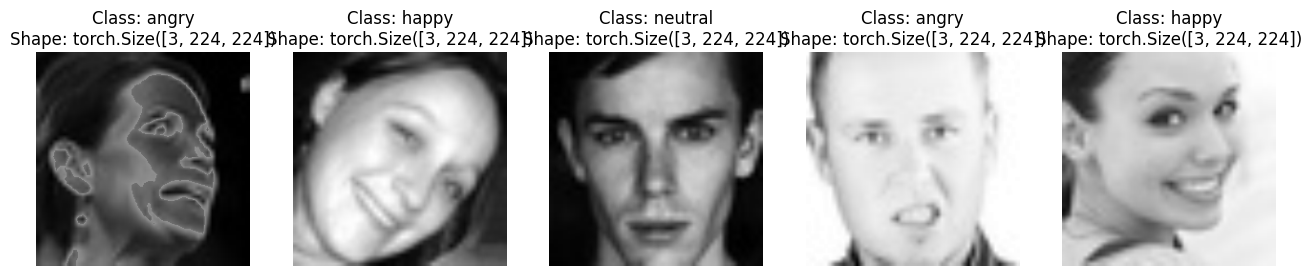

In [41]:
# Display random images from the the Custom Dataset
display_random_images(emotion_train_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

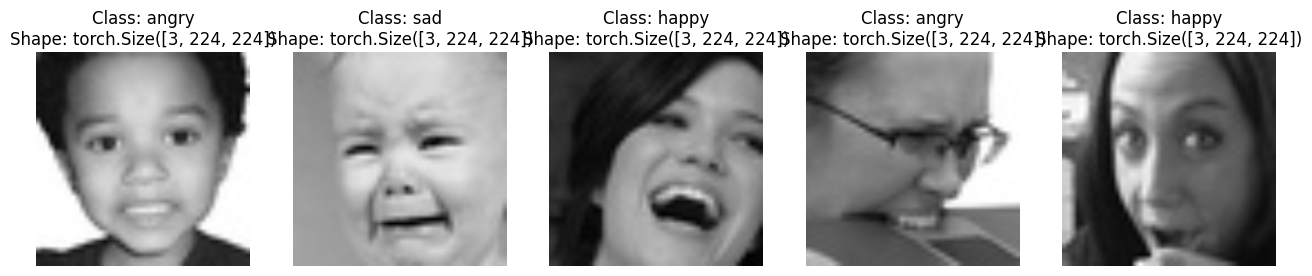

In [42]:
# Display random images from the the Custom Dataset
display_random_images(emotion_test_dataset, n=5,
                     classes=emotion_train_dataset.classes, seed=None)

## 5. Turn all Dataset into DataLoader

In [43]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

# Age Dataset
age_train_dataloader = DataLoader(dataset=age_train_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

age_test_dataloader = DataLoader(dataset=age_test_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

# Gender Dataset
gender_train_dataloader = DataLoader(dataset=gender_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

gender_test_dataloader = DataLoader(dataset=gender_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

# Emotion Dataset
emotion_train_dataloader = DataLoader(dataset=emotion_train_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True, 
                                      num_workers=NUM_WORKERS)

emotion_test_dataloader = DataLoader(dataset=emotion_test_dataset,
                                      batch_size=BATCH_SIZE,
                                      shuffle=False, 
                                      num_workers=NUM_WORKERS)

In [44]:
emotion_train_dataloader.batch_size

64